In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
data_train = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
data_test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')

In [3]:
data_train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
data_train.dtypes

id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [5]:
data_train.isna().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

<Axes: >

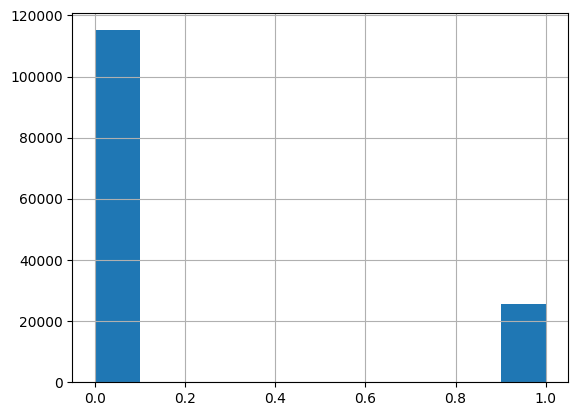

In [6]:
data_train.Depression.hist()

In [7]:
data_train[data_train.select_dtypes(exclude=['object']).columns] = data_train.select_dtypes(exclude=['object']).fillna(0)
data_train[data_train.select_dtypes(include=['object']).columns] = data_train.select_dtypes(include=['object']).fillna('None')

X = data_train.drop(['id', 'Name', 'Depression'], axis=1)
y = data_train.Depression

In [8]:
from sklearn.model_selection import train_test_split
from catboost import Pool

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)

train_pool = Pool(X_train, y_train, cat_features=X_train.select_dtypes(include=['object']).columns.values)

val_pool = Pool(X_val, y_val, cat_features=X_train.select_dtypes(include=['object']).columns.values)

In [10]:
from optuna import create_study
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from catboost import CatBoostClassifier


def objective(trial):
  params = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
      'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
      }

  model = CatBoostClassifier(**params, random_seed=42, task_type='GPU', verbose=0, iterations = 400)
  model.fit(train_pool, eval_set=val_pool)
  y_pred = model.predict_proba(val_pool)
  return eval_metric(val_pool.get_label(), y_pred[:, 1], 'AUC')

sampler = TPESampler(seed=123)
study = create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2024-11-01 19:26:50,443] A new study created in memory with name: no-name-ef274a1c-4e91-40eb-992e-071e410e63be
[I 2024-11-01 19:26:58,456] Trial 0 finished with value: 0.9732532096462855 and parameters: {'learning_rate': 0.07268222670380756, 'depth': 5, 'l2_leaf_reg': 3.041663082077828, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.9732532096462855.
[I 2024-11-01 19:29:44,692] Trial 1 finished with value: 0.9733534088279384 and parameters: {'learning_rate': 0.04807958141120149, 'depth': 10, 'l2_leaf_reg': 7.1634676472637695, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.9733534088279384.
[I 2024-11-01 19:30:01,226] Trial 2 finished with value: 0.9732160162432213 and parameters: {'learning_rate': 0.04088602145357825, 'depth': 8, 'l2_leaf_reg': 4.947150202116619, 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.9733534088279384.
[I 2024-11-01 19:30:07,852] Trial 3 finished with value: 0.9731768661920288 and parameters: {'learning_rate': 0.07641958651588

In [12]:
model = CatBoostClassifier(**study.best_params, random_seed=42, task_type='GPU',)

model.fit(train_pool, verbose=0, eval_set=val_pool)
y_pred = model.predict_proba(val_pool)
eval_metric(val_pool.get_label(), y_pred[:, 1], 'AUC')

[0.9733585268726054]

In [15]:
data_test[data_test.select_dtypes(exclude=['object']).columns] = data_test.select_dtypes(exclude=['object']).fillna(0)
data_test[data_test.select_dtypes(include=['object']).columns] = data_test.select_dtypes(include=['object']).fillna('None')

data_test = data_test.drop(['id', 'Name'], axis=1)

y_pred = model.predict(data_test)

sample_submission['Depression'] = y_pred
sample_submission.to_csv('submission.csv', index=False)